## Lecture 2: CS 20 TensorFlow
Following lecture notes from the class

### Review previous lecture
TensorFlow separates definition of computations from their executions

Phase 1: Assemble a graph of operations
Phase 2: Use a session to feed value and execute the operations in the graph

#### Constants
- Constant values are stored in the graph definition; use they carefully or graph gets bloated
- Sessions allocate memory to store variable; two different sessions can hold two different value for the same variable

#### Feed Dict
- Feed dict feeds values into placeholders with a dictionary.
- Easy to use, but has impact on perf

#### Lazy loading
- Separate the assembling of graph and the execution of operations.
- Use python attribute to ensure function is only loaded the first time its called.

### Linear Regression
Inference Y_predicted = w*x + b
Mean Squqared Error  = E((y - y_predicted))


In [1]:
import os
import time

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import examples.utils as utils

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
DATA_FILE = 'examples/data/birth_life_2010.txt'

In [4]:
DATA_FILE

'examples/data/birth_life_2010.txt'

In [5]:
# Step1 : Read in the data from the text file
data, n_samples = utils.read_birth_life_data(DATA_FILE)

In [6]:
data[0:10,1]

array([74.82825 , 70.81949 , 72.15066 , 61.999855, 73.92766 , 67.465195,
       81.641464, 72.30639 , 68.484314, 62.44061 ], dtype=float32)

In [7]:
print("Dimensions of the data set", np.shape(data))

Dimensions of the data set (190, 2)


In [8]:
# Step 2: Create placeholders for X(Birth Rate) and Y( life expectancy)
# Note that both X and Y are scalars with type float
tf.reset_default_graph()
X = tf.placeholder(tf.float32, name = "X")
Y = tf.placeholder(tf.float32, name = "Y")

In [9]:
# Step 3: Create Weight and bias and initialize them to 0
w = tf.get_variable("weights", initializer = tf.constant(0.0)) # Shape is not needed when with tf.Session() as sess:
'''
w = tf.Variable(0, dtype = tf.float32)
cost = tf.add(tf.add(w**2,tf.multiply(-10.0,w)), 25)
tf.global_variables_initializer().run()
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

for _ in range(100):
    train.run()
     
w_val = w.eval()

print(w_val)#having constant initializer
'''



'\nw = tf.Variable(0, dtype = tf.float32)\ncost = tf.add(tf.add(w**2,tf.multiply(-10.0,w)), 25)\ntf.global_variables_initializer().run()\ntrain = tf.train.GradientDescentOptimizer(0.01).minimize(cost)\n\nfor _ in range(100):\n    train.run()\n     \nw_val = w.eval()\n\nprint(w_val)#having constant initializer\n'

In [10]:
b = tf.get_variable("bias", initializer = tf.constant(0.0))

In [11]:
# Step 4 : Build the model to predict y
Y_predicted = w * X + b

In [12]:
# Step 5: Use the squared error as the loss function

loss = tf.square(Y - Y_predicted, name = "loss")

In [13]:
# Step 6: Create Optimizer:  Using Gradient descent to minimize the loss
opt = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
optimizer = opt.minimize(loss)

In [14]:
# Write the log files using a FileWriter
writer = tf.summary.FileWriter('./graphs/linear_reg', tf.get_default_graph())

In [15]:
# Step 7:Initialize the variable and run optimizer by feeding with dict

with tf.Session() as sess:
    # Initializing the variables w and b
    sess.run(tf.global_variables_initializer())
    
    #Step 8: Train the model for 100 epochs
    for i in range(100):
        total_loss = 0
        for x, y in data:
            # Execute the optimizer and fetch the value of the loss
            _, l = sess.run([optimizer,loss],feed_dict = {X:x,Y:y})
            total_loss = total_loss + l
        if(i%20 ==0):
            print("Epoch {0}: Avg Loss {1}".format(i, total_loss/n_samples))
    
    #Close the graph writer        
    writer.close()
    
    # Get, final values of w and b
    w_out, b_out = sess.run([w,b])

Epoch 0: Avg Loss 1661.8637834631543
Epoch 20: Avg Loss 119.20935661137888
Epoch 40: Avg Loss 37.305591759538146
Epoch 60: Avg Loss 30.524590178362192
Epoch 80: Avg Loss 30.04458791257593


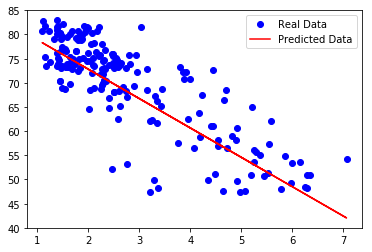

In [17]:
plt.plot(data[:,0],data[:,1],'bo', label = "Real Data")
plt.plot(data[:,0],data[:,0]*w_out + b_out,'r', label = "Predicted Data")
plt.legend()
plt.show()

### Hubert loss:
- Regular linear regression has problem with outliers.
- Hubert Loss: A way for outliers to havtf.reset_default_graph()e less impact on the result.

- Can use if (tf.abs(y_predicted-y)< = delta:
-    #do something
- However, it can only be done in "eager execution mode" (will tackle lateR) 

- will use tf.cond which has has the format
    tf.cond(pred, true_function, false_function

In [118]:
def huber_loss(labels, pred,delta = 14.0):
    residual = tf.abs(labels-pred)
    def f1(): return 0.5*tf.square(residual)
    def f2(): return delta*residual - 0.5*tf.square(delta)
    return tf.cond(residual < delta, f1, f2)


In [119]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, name ="x")
y = tf.placeholder(tf.float32, name = "y")

In [120]:
w = tf.get_variable("weights", initializer = tf.constant(0.0))
b = tf.get_variable("bias", initializer = tf.constant(0.0))

In [121]:
ypred = w*x + b

In [122]:
loss = huber_loss(y, ypred,delta = 14.0)
#loss = tf.square(y-ypred, name = "loss")

In [123]:
opt = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [127]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(100):
        total_loss = 0
        for j,k in data:
            _,l = sess.run([opt,loss], feed_dict={x:j,y:k})
            total_loss = total_loss + l
        
        if(i%20 ==0):
            print("Iteration={0}--Loss={1}".format(i,total_loss/n_samples))
     
    w_out = w.eval()
    b_out = b.eval()
print("w:",w_out)
print("b:",b_out)

Iteration=0-Loss=712.534996434
Iteration=20-Loss=262.260425842
Iteration=40-Loss=162.846115277
Iteration=60-Loss=78.8100727632
Iteration=80-Loss=33.1407740321
('w:', -4.2249994)
('b:', 78.485054)


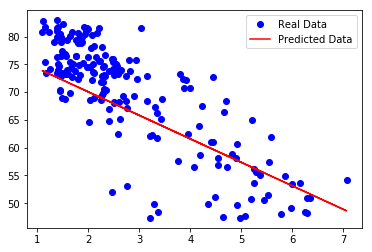

In [128]:
plt.plot(data[:,0],data[:,1],'bo', label = "Real Data")
plt.plot(data[:,0],data[:,0]*w_out + b_out,'r', label = "Predicted Data")
plt.legend()
plt.show()

## Handling Data parallely

- With feed_dicts data processing is outside tensorflow:- makes it easier to shuffle, batch and generate arbitrary data
- Drawback: Can slow down the program
- users often process data in single thread, creating bottleneck

### Another Option: Queues
- TF offers queues for handling data.
- provides performance and allows pipelining, threading and reduces time for loading data into placeholders
- Cons: Unstable, prone to crashing

New better way: tf.data module
- faster than placeholders
- easier than queue
- stable

How to change the existing model ?
- Earlier stored input data in numpy array.
- Each row = datapoint
- to get this data into TF, created placeholders
- Then iterate through each datapoint and feed into feed_dict

Idea is to use batches of data points
- feeding data in numpy array to tf model is low
- with tf.data input is tored in tf.data.Dataset object

e.g tf.Dataset.from_tensor_slices((feature,labels))

In [131]:
n_samples

190

In [145]:
tf.reset_default_graph()

dataset = tf.data.Dataset.from_tensor_slices((data[:,0],data[:,1])) #<--Note
iterator = dataset.make_initializable_iterator() #<-- Note
x,y = iterator.get_next() #<-- Note

'''
placeholder definitions for x and y are not needed
x = tf.placeholder(tf.float32, name = 'x') 
y = tf.placeholder(tf.float32, name  = 'y')
'''
w = tf.get_variable(name = "weight", initializer = tf.constant(0.0))
b = tf.get_variable(name = "bias", initializer = tf.constant(0.0))

ypred = w*x + b
loss = tf.square(y-ypred, name = "loss")

opt = tf.train.GradientDescentOptimizer(learning_rate = 0.001).minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(100):
        sess.run(iterator.initializer) #<-- Initialize Itertor
        total_loss = 0
        k = 0   
        try:
            while True:
                _,l = sess.run([opt,loss]) #<-- Each time this is called, iterator gets the next x,y pair
                total_loss += l
                k +=1
        except tf.errors.OutOfRangeError:
            pass
        
    
        if(i%20==0):
            print("{0} Iteration, Loss = {1}".format(i,total_loss/n_samples))

    w_out = w.eval()
    b_out = b.eval(_)
    print(k)

0 Iteration, Loss = 1661.86378346
20 Iteration, Loss = 119.209356611
40 Iteration, Loss = 37.3055917595
60 Iteration, Loss = 30.5245901784
80 Iteration, Loss = 30.0445879126
190


### Note about Optimizer
- Opt = tf.train.GradientDescentOptimizer(learning_rate = 0.001).minimize(loss)
- optimizer is an op -> for minimizing loss
- Tf executes optimizer and will execute part of graph this op depends on.
- opt depends on loss which in turn depends on y and ypred; ypred depends on w,x and b
- By default, optimizer trains all trainable variables its objective function depends on.
- variables that should not be trained, can be indicated by setting trainable = False